In [1]:
#!/usr/bin/env python

"""
Script: generate_triplets.py
----------------------------
Generates triplet (query, positive, negative) samples for VPR training using
the user-supplied CSV metadata for mapped and random data.

Assumptions:
  - mapped_meta.csv has columns:  [image_idx, env_idx, x, z]
  - random_meta.csv has columns:  [image_idx, env_idx, x, z, valid_neighbours]
     where 'valid_neighbours' is a semicolon-separated list of image_idx that are 
     valid positives for the given row.
  - Mapped images are stored in some MAPPED_DIR, random images in RANDOM_DIR (optional).
  - You will adapt directory paths and negative-selection logic as needed.

Output:
  - A CSV file named 'triplets.csv' with columns:
       query_image, positive_image, negative_image
    which can be loaded by the training script.
"""

import pandas as pd
import numpy as np

# ------------------------- CONFIGURATIONS ------------------------- #
MAPPED_META_PATH = "../data/csv/mapped_metadata.csv"
RANDOM_META_PATH = "../data/csv/random_metadata.csv"
OUTPUT_TRIPLETS_CSV = "../data/csv/triplets.csv"

# Distance threshold for deciding a "far" negative (adjust to your scenario)
NEGATIVE_DISTANCE_THRESHOLD = 200.0

# ------------------------------------------------------------------ #

def euclidean_distance(x1, z1, x2, z2):
    """Compute Euclidean distance in the (x,z) plane."""
    return np.sqrt((x1 - x2) ** 2 + (z1 - z2) ** 2)

def main():
    # Load CSVs
    mapped_df = pd.read_csv(MAPPED_META_PATH)
    random_df = pd.read_csv(RANDOM_META_PATH)

    # Combine data if you need a global search pool for negatives.
    # For example, you might want to pick negatives from both mapped and random sets.
    all_df = pd.concat([mapped_df, random_df], ignore_index=True)

    # Build a convenient structure for negative search
    # e.g., group by environment for quick filtering
    env_to_records = {}
    for i, row in all_df.iterrows():
        env = row["env_idx"]
        if env not in env_to_records:
            env_to_records[env] = []
        env_to_records[env].append((row["image_idx"], row["x"], row["z"]))

    triplets = []

    # Generate triplets using random_df as "query" examples
    for i, row in random_df.iterrows():
        query_img = row["image_idx"]
        q_env = row["env_idx"]
        q_x, q_z = float(row["x"]), float(row["z"])

        # Parse valid neighbours for positives
        valid_neighbours_str = str(row["valid_neighbours"]).strip()
        if not valid_neighbours_str or valid_neighbours_str.lower() == "nan":
            # If no valid neighbours listed, skip
            continue

        positive_list = valid_neighbours_str.split(";")

        # For negative selection, pick from the same environment (or different, adapt as needed)
        # that is "far" from the query. 
        candidate_negatives = []
        if q_env in env_to_records:
            for (img_idx, nx, nz) in env_to_records[q_env]:
                dist = euclidean_distance(q_x, q_z, nx, nz)
                # We'll define a negative as anything beyond a threshold 
                # and obviously not in the positive list
                if dist > NEGATIVE_DISTANCE_THRESHOLD and img_idx not in positive_list and img_idx != query_img:
                    candidate_negatives.append(img_idx)

        # If no negatives found under these constraints, skip
        if len(candidate_negatives) == 0:
            continue

        # Create triplets for each valid positive
        for pos_img in positive_list:
            # Randomly select one negative from the candidate list
            neg_img = np.random.choice(candidate_negatives)
            triplets.append([query_img, pos_img, neg_img])

    # Convert to DataFrame and save
    triplet_df = pd.DataFrame(triplets, columns=["query_image", "positive_image", "negative_image"])
    triplet_df.to_csv(OUTPUT_TRIPLETS_CSV, index=False)
    print(f"Triplets generated: {len(triplets)}")
    print(f"Saved triplets to {OUTPUT_TRIPLETS_CSV}")

if __name__ == "__main__":
    main()


Triplets generated: 610
Saved triplets to ../data/csv/triplets.csv


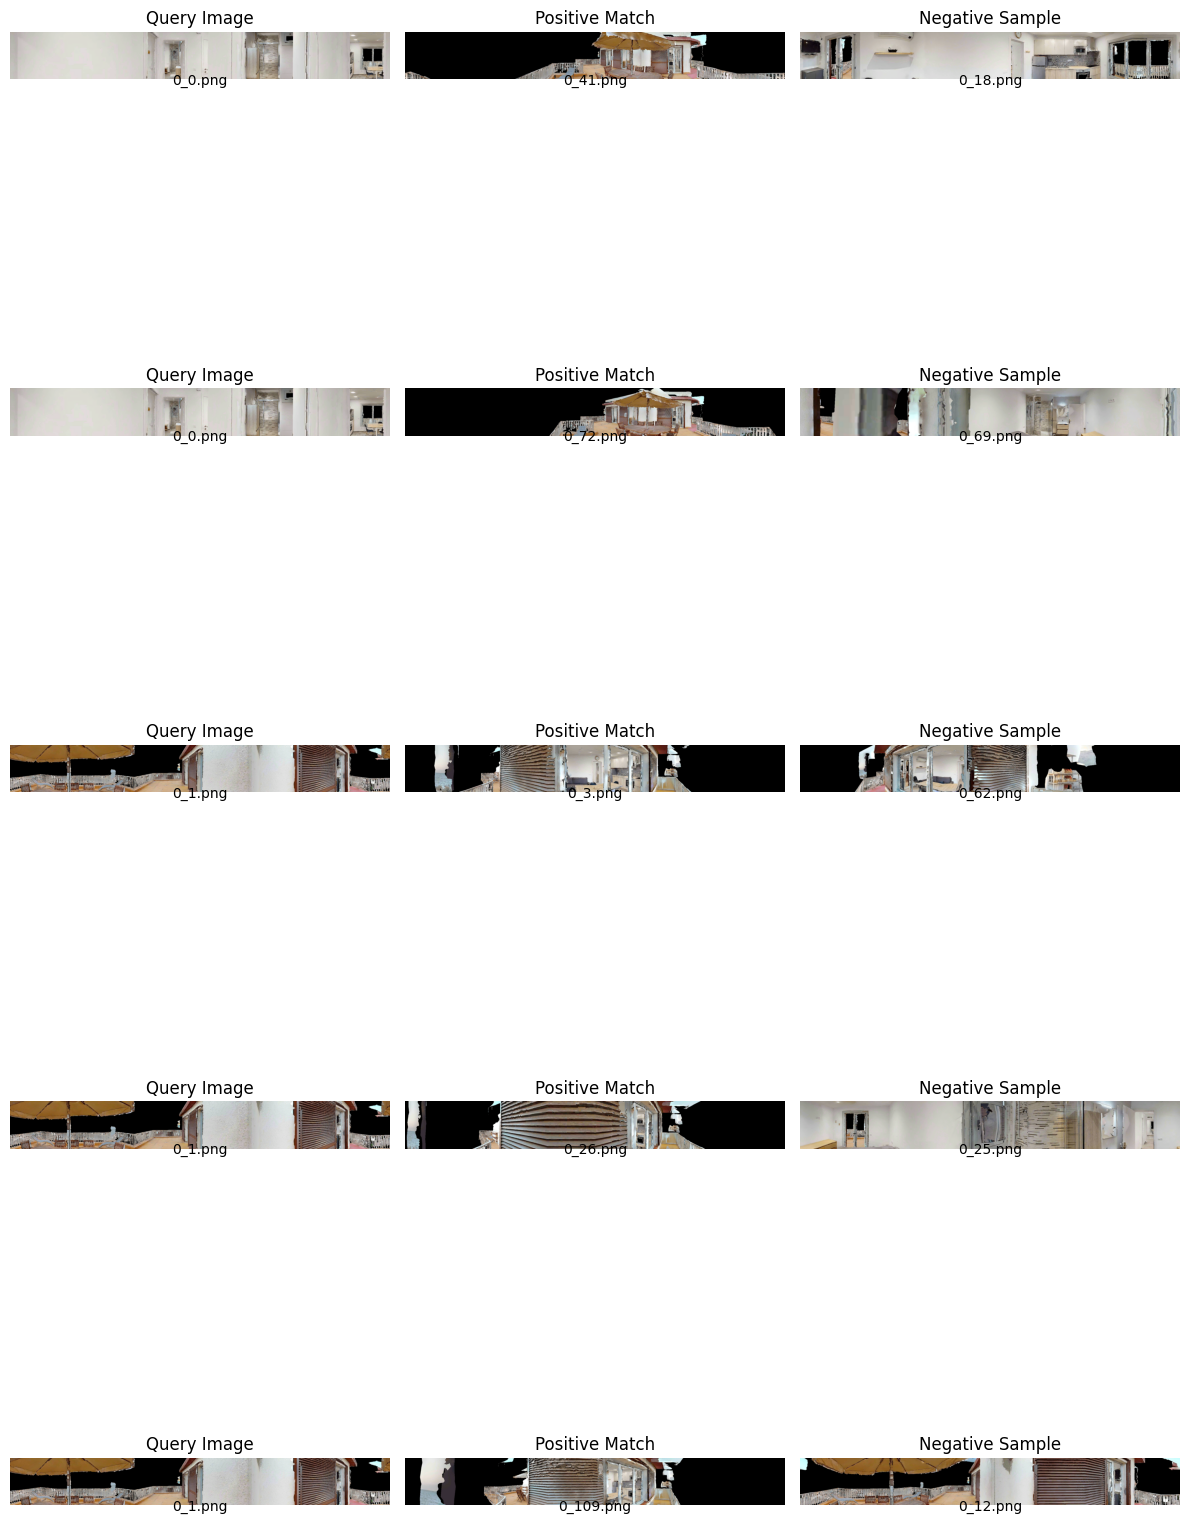

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from PIL import Image

# ------------------------- CONFIGURATIONS ------------------------- #
TRIPLETS_CSV = "../data/csv/triplets.csv"
MAPPED_IMAGE_DIR = "../data/mapped_images"   
RANDOM_IMAGE_DIR = "../data/random_images"   
# ------------------------------------------------------------------ #

def load_query_image(img_name):
    """Load an image from the mapped or random directories."""
    path = os.path.join(RANDOM_IMAGE_DIR, img_name)

    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def load_mapped_image(img_name):
    """Load an image from the mapped or random directories."""
    path = os.path.join(MAPPED_IMAGE_DIR, img_name)

    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def plot_triplets(triplets_csv, num_triplets=5):
    """
    Plots the first `num_triplets` triplets from the dataset.

    - Query (Left)
    - Positive Match (Middle)
    - Negative Sample (Right)

    Displays the image filenames underneath each image.
    """

    # Load triplets CSV
    triplet_df = pd.read_csv(triplets_csv)

    # Select the first `num_triplets` samples
    sample_triplets = triplet_df.head(num_triplets)

    fig, axes = plt.subplots(num_triplets, 3, figsize=(12, 4 * num_triplets))

    for i, row in enumerate(sample_triplets.itertuples()):
        query_img_name = row.query_image
        positive_img_name = row.positive_image
        negative_img_name = row.negative_image

        query_img = load_query_image(query_img_name)
        positive_img = load_mapped_image(positive_img_name)
        negative_img = load_mapped_image(negative_img_name)

        # Plot Query
        axes[i, 0].imshow(query_img)
        axes[i, 0].set_title("Query Image", fontsize=12)
        axes[i, 0].axis("off")
        axes[i, 0].text(0.5, -0.1, query_img_name, fontsize=10, ha="center", transform=axes[i, 0].transAxes)

        # Plot Positive Match
        axes[i, 1].imshow(positive_img)
        axes[i, 1].set_title("Positive Match", fontsize=12)
        axes[i, 1].axis("off")
        axes[i, 1].text(0.5, -0.1, positive_img_name, fontsize=10, ha="center", transform=axes[i, 1].transAxes)

        # Plot Negative Sample
        axes[i, 2].imshow(negative_img)
        axes[i, 2].set_title("Negative Sample", fontsize=12)
        axes[i, 2].axis("off")
        axes[i, 2].text(0.5, -0.1, negative_img_name, fontsize=10, ha="center", transform=axes[i, 2].transAxes)

    plt.tight_layout()
    plt.show()

# Run the function to visualize the triplets
plot_triplets(TRIPLETS_CSV, num_triplets=5)
